In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os

In [ ]:
class SiameseDataset():
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.train_df=pd.read_csv(training_csv)
        self.train_df.columns =["image1","image2","label"]
        self.train_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        # getting the image path
        image1_path=os.path.join(self.train_dir,self.train_df.iat[index,0])
        image2_path=os.path.join(self.train_dir,self.train_df.iat[index,1])
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , torch.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))
    def __len__(self):
        return len(self.train_df)

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
# Load the the dataset from raw image folders
# Load the test dataset
training_dir = '/content/gdrive/MyDrive/train'
training_csv = '/content/gdrive/MyDrive/train_data.csv'
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

In [ ]:
 # Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch


class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()


In [ ]:
# net = SiameseNetwork().cuda()
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)


In [ ]:
#train the model
def train(train_dataloader):
    loss=[] 
    counter=[]
    iteration_number = 0
    for i, data in enumerate(train_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      # img0, img1 , label = img0, img1, label
      optimizer.zero_grad()
      output1,output2 = net(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss_contrastive.backward()
      optimizer.step()
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(train_dataloader)


def eval(eval_dataloader):
    loss=[] 
    counter=[]
    iteration_number = 0
    for i, data in enumerate(eval_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      output1,output2 = net(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(eval_dataloader)

In [ ]:
epochs = 10
for epoch in range(1,epochs):
  best_eval_loss = 9999
  train_loss = train(train_dataloader)
  eval_loss = eval(train_dataloader)

  print(f"Training loss{train_loss}")
  print("-"*20)
  print(f"Eval loss{eval_loss}")

  if eval_loss<best_eval_loss:
    best_eval_loss = eval_loss
    print("-"*20)
    print(f"Best Eval loss{best_eval_loss}")
    torch.save(net.state_dict(), "/content/model.pth")
    print("Model Saved Successfully") 

Training loss0.0015902174187560202
--------------------
Eval loss0.001588084211835773
--------------------
Best Eval loss0.001588084211835773
Model Saved Successfully
Training loss0.001589902132580608
--------------------
Eval loss0.0015885857548928386
--------------------
Best Eval loss0.0015885857548928386
Model Saved Successfully
Training loss0.0015924950234004424
--------------------
Eval loss0.0015840804899212644
--------------------
Best Eval loss0.0015840804899212644
Model Saved Successfully
Training loss0.0015852334826058573
--------------------
Eval loss0.001596713928219573
--------------------
Best Eval loss0.001596713928219573
Model Saved Successfully
Training loss0.0015871209534114783
--------------------
Eval loss0.001586889000381862
--------------------
Best Eval loss0.001586889000381862
Model Saved Successfully
Training loss0.0015913966648012437
--------------------
Eval loss0.0015796556023801806
--------------------
Best Eval loss0.0015796556023801806
Model Saved Succes

In [ ]:
def train():
    loss=[] 
    counter=[]
    iteration_number = 0
    for epoch in range(1,20):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()    
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)   
    return net
#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train()
torch.save(model.state_dict(), "model.pth")
print("Model Saved Successfully") 

In [ ]:
model = SiameseNetwork().cuda()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/model.pth'))


<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


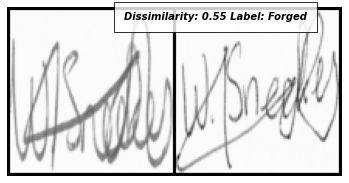

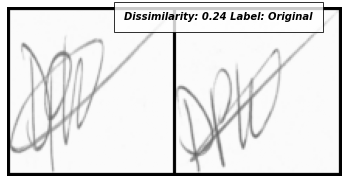

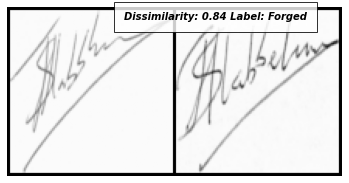

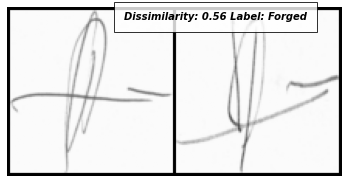

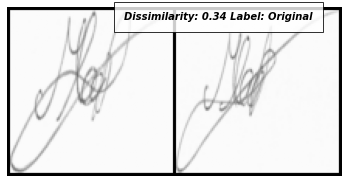

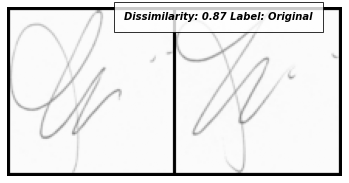

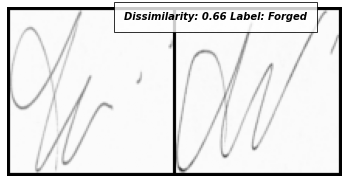

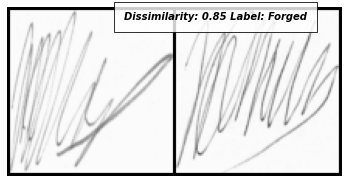

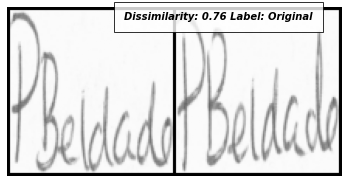

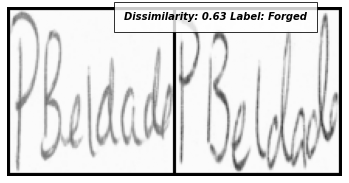

In [ ]:
# Load the test dataset
testing_dir = '/content/gdrive/MyDrive/test'
testing_csv = '/content/gdrive/MyDrive/test_data.csv'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

counter = 0 
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

for i, data in enumerate(test_dataloader, 0):
  x0, x1, label = data
  concatenated = torch.cat((x0, x1),0)
  op1, op2 = model(x0.to(device), x1.to(device))
  euc_dist = F.pairwise_distance(op1, op2)

  if label==list_0:
    label="Original"
  else:
    label="Forged"

  imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f} Label: {label}')
  counter+=1
  if counter==10:
    break

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q streamlit


     |████████████████████████████████| 9.2 MB 16.6 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 182 kB 59.0 MB/s 
     |████████████████████████████████| 164 kB 72.8 MB/s 
     |████████████████████████████████| 237 kB 57.1 MB/s 
     |████████████████████████████████| 4.7 MB 71.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 


In [ ]:
%%sh
# get ngrok
curl -O https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.1M  100 13.1M    0     0  43.8M      0 --:--:-- --:--:-- --:--:-- 43.8M


In [ ]:
!./ngrok authtoken 2GFXL3kqGEdSot35hNTQgVn7h0Y_7G7LDK9CDYZpWoXUpAHZQ

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 23.8 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=a2ddef1846fea0cd982c9c3f2375ec20626b5d8dc5ed6c7b40d0ab1f71d044f2
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
from pyngrok import ngrok 
public_url = ngrok.connect(port='8501')
public_url

<NgrokTunnel: "http://48bf-35-245-135-215.ngrok.io" -> "http://localhost:80">

In [ ]:
%%writefile streamlit_app.py 
import streamlit as st 
st.markdown(""" This is a Streamlit App """)

Overwriting streamlit_app.py


In [ ]:
%%writefile app.py
import streamlit as st
import streamlit.components.v1 as components
from PIL import Image
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torchvision
from torch.autograd import Variable
from PIL import Image
import io

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

model = SiameseNetwork().cuda()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/model.pth'))



def main():
    st.title("Signature Verfication using Siamese Network")
    menu = ["Home","Run"]
    choice = st.sidebar.selectbox('Menu',menu)
    if choice == 'Home':
        st.subheader("Project for DL")	
    elif choice == 'Run':
        uploaded_files = st.file_uploader('Select', type = ['jpg', 'png', 'jpeg'],help="Charger une image au format jpg,jpeg,png", accept_multiple_files=True,)
        bytes_data = uploaded_files[0].read()
        img0 = Image.open(io.BytesIO(bytes_data))
        st.write("filename:", uploaded_files[0].name)
        st.image(img0)
        bytes_data = uploaded_files[1].read()
        img1 = Image.open(io.BytesIO(bytes_data))
        st.write("filename:", uploaded_files[1].name)
        st.image(img1)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        transform=transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])
        img0 = transform(img0)
        img1 = transform(img1)
        concatenated = torch.cat((img0, img1),0)
        op1, op2 = model(img0.to(device), img1.to(device))
        euc_dist = F.pairwise_distance(op1, op2)
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f} Label: {label}')
        

if __name__ == '__main__':
	main()



Overwriting app.py


In [ ]:
!streamlit run app.py --server.port 80 &>/dev/null&

In [ ]:
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='8501')
public_url

<NgrokTunnel: "http://2c42-35-245-135-215.ngrok.io" -> "http://localhost:80">

In [ ]:
ngrok.kill()

In [ ]:
!streamlit run /content/streamlit_app.py & npx lt -- port 8501

2022-10-17 05:49:15.362 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
npx: installed 1 in 1.489s
command not found: lt



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.245.135.215:8501

  Stopping...
